<a href="https://colab.research.google.com/github/rahiakela/data-science-research-and-practice/blob/main/data-science-bookcamp/case-study-2--online-ad-clicks/03_statistical_hypothesis_testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Statistical hypothesis testing

Many ordinary people are forced to make hard choices every day. This is especially
true of jurors in the American justice system. Jurors preside over a defendant’s fate
during a trial. 

They consider the evidence and then decide between two competing
hypotheses:

* The defendant is innocent.
* The defendant is guilty.

The two hypotheses are not weighted equally: the defendant is presumed to be
innocent until proven guilty. Thus, the jurors assume that the innocence hypothesis
is true. They can only reject the innocence hypothesis if the prosecution’s evidence
is convincing. Yet the evidence is rarely 100% conclusive, and some doubt of
the defendant’s guilt remains. That doubt is factored into the legal process.

The jury is instructed to accept the innocence hypothesis if there is “reasonable doubt” of the defendant’s guilt. They can only reject the innocence hypothesis if the defendant
appears guilty “beyond a reasonable doubt.”

Reasonable doubt is an abstract concept that’s hard to define precisely. Nonetheless,
we can distinguish between reasonable and unreasonable doubt across a range of
real-world scenarios.

In our scenarios, the jurors are carrying out a statistical hypothesis test. Such tests
allow statisticians to choose between two competing hypotheses, both of which arise
from uncertain data. One of the hypotheses is accepted or rejected based on a measured
level of doubt.

In this notebook, we explore several well-known statistical hypothesis
testing techniques. We begin with a simple test to measure whether a sample mean
noticeably deviates from an existing population.

##Setup

In [1]:
from collections import defaultdict
import itertools

import numpy as np
from scipy import stats
import math

import matplotlib.pyplot as plt

In [2]:
# Penalizing centers using the squared distance from the minimum
def squared_distance(value1, value2):
  return (value1 - value2) ** 2

In [3]:
# Penalizing centers using the total sum of squared distances
def sum_of_squared_distances(value, measurements):
  return sum(squared_distance(value, m) for m in measurements)

In [4]:
# Computing California’s sum of squares
def sum_of_squares(data):
  mean = np.mean(data)
  return sum(squared_distance(value, mean) for value in data)

In [5]:
# Computing the variance from mean squared distance
def variance(data):
  mean = np.mean(data)
  return np.mean([squared_distance(value, mean) for value in data])

In [6]:
# Computing the weighted variance using np.average
def weighted_variance(data, weights):
  mean = np.average(data, weights=weights)
  squared_distances = [squared_distance(value, mean) for value in data]
  return np.average(squared_distances, weights=weights)

assert weighted_variance([75, 77], [9, 1]) == np.var(9 * [75] + [77])

##Divergence between sample and population mean

Now, let’s
imagine a scenario where we analyze every fifth-grade classroom in North Dakota.
One spring day, all fifth graders in the state are given the same assessment exam. The
exam grades are fed into North Dakota’s assessment database, and the population
mean and variance are computed across all grades in the state. According to the
records, the population mean is 80, and the population variance is 100.

In [7]:
# Population mean and variance of North Dakota grades
population_mean = 80
population_variance = 100

Let’s temporarily assume that the null hypothesis is true and both Dakotas share
the same population mean and variance.

In [8]:
# Normal curve parameters if the null hypothesis is true
mean = population_mean
sem = (population_variance / 18) ** 0.5

If the null hypothesis is true, the probability of encountering an average exam grade
of at least 84% is equal to `stats.norm.sf(84 mean, sem)`. 

Let’s check that probability.

In [9]:
# Finding the probability of a high-performance grade
prob_high_grade = stats.norm.sf(84, mean, sem)
print(f"Probability of an average grade >= 84 is {prob_high_grade}")

Probability of an average grade >= 84 is 0.044843010885182284


We will now compute the probability of observing an exam average that’s less than
or equal to 76%.

The calculation can be carried out with SciPy’s `stats.norm.cdf`
method, which computes the cumulative distribution function of the normal curve.

A cumulative distribution function is the direct opposite of the survival function.

We now use `stats.norm.cdf` to find the probability of observing an unusually low average grade.

In [10]:
# Finding the probability of a low-performance grade
prob_low_grade = stats.norm.cdf(76, mean, sem)
print(f"Probability of an average grade <= 76 is {prob_low_grade}")

Probability of an average grade <= 76 is 0.044843010885182284


It appears that `prob_low_grade` is equal to `prob_high_grade`. This equality arises
from the symmetric shape of the normal curve. 

The cumulative distribution and the
survival function are mirror images that are reflected across the mean. 

Thus,
`stats.norm.sf(mean + x, mean, sem)` always equals `stats.norm.cdf(mean - x, mean, sem)` for any input x. 

Next, we visualize both functions to confirm their reflection
across a vertically plotted mean.

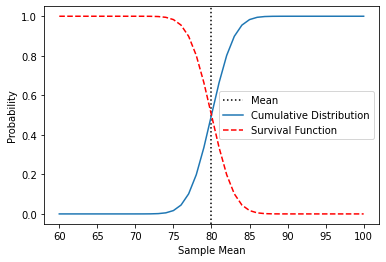

In [12]:
# Comparing the survival and cumulative distribution functions
for x in range(-100, 100):
  sf_value = stats.norm.sf(mean + x, mean, sem)
  assert sf_value == stats.norm.cdf(mean - x, mean, sem)

plt.axvline(mean, color="k", label="Mean", linestyle=":")
x_values = range(60, 101)
plt.plot(x_values, stats.norm.cdf(x_values, mean, sem), label="Cumulative Distribution")
plt.plot(x_values, stats.norm.sf(x_values, mean, sem), label="Survival Function", color="r", linestyle="--")
plt.legend()
plt.xlabel("Sample Mean")
plt.ylabel("Probability")
plt.show()

Now we are ready to sum `prob_high_grade` and `prob_low_grade`. Due to symmetry, that sum equals `2 * prob_high_grade`.

Conceptually, the sum represents the probability
of observing an extreme deviation from the population mean when the null hypothesis
is true. Statisticians refer to this null-hypothesis-driven probability as the `p-value`.

In [14]:
# Computing the null-hypothesis-driven p-value
p_value = prob_low_grade + prob_high_grade
assert p_value == 2 * prob_high_grade

print(f"The p-value is {p_value}")

The p-value is 0.08968602177036457


Under the null hypothesis, there is approximately a 9% chance of observing the grade
extreme at random. 

It’s therefore plausible that the null hypothesis is true and the
extreme test average is just a random fluctuation.

Let’s check if that slight grade shift would have influenced our p-value.

In [15]:
# Computing the p-value for an adjusted sample mean
def compute_p_value(observed_mean, population_mean, sem):
  mean_diff = abs(population_mean - observed_mean)
  prob_high = stats.norm.sf(population_mean + mean_diff, population_mean, sem)
  return 2 * prob_high

In [16]:
new_p_value = compute_p_value(85, mean, sem)
print(f"The updated p-value is {new_p_value}")

The updated p-value is 0.03389485352468927


A tiny increase in the average grade has caused a threefold decrease in the p-value.

Now,
under the null hypothesis, there’s only a 3.3% chance of observing an average test grade
that’s at least as extreme as 85%. This likelihood is low, and we might therefore be
tempted to reject the null hypothesis.

This is not an easy question to answer. Generally, statisticians tend to reject the null
hypothesis if the p-value is less than or equal to 0.05. The threshold of 0.05 is called
the significance level, and p-values below that threshold are deemed to be statistically significant.

Unfortunately, the threshold of 0.05 doesn’t actually arise from the laws of mathematics
and statistics: it’s an ad hoc value chosen by the academic community as a requirement
for research publication.

As a consequence, many research journals are flooded
with type I errors. A type I error is defined as an erroneous rejection of the null hypothesis.
Such errors occur when random data fluctuations are interpreted as genuine
deviations from the population mean.

But there is currently no consensus on whether using a lower threshold
is appropriate, since doing so would lead to an increase in type II errors, in which we
wrongly reject the alternative hypothesis.

Selecting an optimal significance level is difficult. Nevertheless, let’s temporarily
set the significance level to a very stringent value of 0.001.

In [18]:
# Scanning for a stringent p-value result
for grade in range(80, 100):
  p_value = compute_p_value(grade, mean, sem)
  if p_value < 0.001:
    break

print(f"An average grade of {grade} leads to a p-value of {p_value}")

An average grade of 88 leads to a p-value of 0.0006885138966450773


Given the new threshold, we would require an average grade of at least 88% to reject
the null hypothesis. Thus, an average grade of 87% would not be considered statistically
significant, even though it’s noticeably higher than the population mean.

Our
lowering of the cutoff has inevitably exposed us to an increased risk of type II errors.

But we also proceed with excessive caution to avoid erroneously rejecting the
null hypothesis. 

In particular, we do our best to minimize the most common cause of
type I errors and the topic of the next subsection: **data dredging**.

##Data dredging

array([45, 48, 65, ..., 79, 50, 75])

How do we compute the average age of the residents?

One cumbersome approach
would be to take a census of every resident in the town. We could record all 50,000 ages and then compute their mean.

That exact mean would cover the entire population,
which is why it’s called the **population mean**. 

Furthermore, the variance of an entire population is referred to as the **population variance**.

In [ ]:
# Computing the population mean and variance
population_mean = population_ages.mean()
population_variance = population_ages.var()

print(f"Population mean: {population_mean:.2f}")
print(f"Population variance: {population_variance:.2f}")

Population mean: 42.53
Population variance: 584.33


However,
obtaining that data in real life would be incredibly time consuming. We would have to
interview all 50,000 people. Without more resources, interviewing the whole town
would be borderline impossible.

A simpler approach would be to interview 10 randomly chosen people in the town.
We’d record the ages from this random sample and then compute the sample mean.

Let’s simulate the sampling process by drawing 10 random ages.

In [ ]:
# Simulating 10 interviewed people
np.random.seed(0)

sample_size = 10
sample = np.random.choice(population_ages, size=sample_size)
sample_mean = sample.mean()

print(f"Sample mean: {sample_mean:.2f}")

Sample mean: 30.80


Of course, our sample mean is likely to be noisy and inexact. 

We can measure that noise by finding the percent difference between `sample_mean` and `population_mean`.

In [ ]:
# Comparing the sample mean to the population mean
percent_diff = lambda v1, v2: 100 * abs(v1 - v2) / v2

percent_diff_means = percent_diff(sample_mean, population_mean)
print(f"There is a {percent_diff_means:.2f} percent difference between means.")

There is a 27.59 percent difference between means.


Clearly, our sample is insufficient to estimate the mean—we need to gather
more samples. Perhaps we should increase our sampling to cover 1,000 residents of the town.

Unfortunately, interviewing 1,000 people will still be very time consuming:
even if we assume an idealistic interview rate of 2 people per minute, it will
take us eight hours to reach our interview goal. 

Conceivably, we can optimize our time by parallelizing the interview process.

In [ ]:
# Computing sample means across 1,000 people
np.random.seed(0)

sample_means = [np.random.choice(population_ages, size=sample_size).mean() for _ in range(1000)]

**According to the central limit theorem, a histogram of sample means should resemble the normal distribution**. 

Furthermore, the mean of the normal distribution should
approximate the population mean. 

We can confirm that this is the case by fitting the
sample means to a normal distribution.

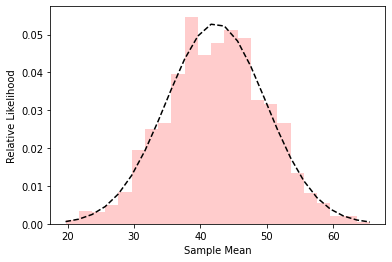

In [ ]:
# Fitting sample means to a normal curve
likelihoods, bin_edges, _ = plt.hist(sample_means, bins="auto", alpha=0.2, color="r", density=True)
mean, std = stats.norm.fit(sample_means)
normal_likelihoods = stats.norm.pdf(bin_edges, mean, std)

plt.plot(bin_edges, normal_likelihoods, color="k", linestyle="--")
plt.xlabel("Sample Mean")
plt.ylabel("Relative Likelihood")
plt.show()

Our histogram is not very smooth because we’ve only processed 100 data points. However,
the histogram’s shape still approximates a normal distribution.



In [ ]:
# Comparing the normal mean to the population mean
print(f"Actual population mean is approximately {population_mean:.2f}")

percent_diff_means = percent_diff(mean, population_mean)
print(f"There is a {percent_diff_means:.2f} difference between means.")

Actual population mean is approximately 42.53
There is a 0.45 difference between means.


Thus our result, while not perfect, is still a very good approximation of
the actual average age within the town.

Now, we briefly turn our attention to the standard deviation computed from the
normal distribution.

**Squaring the standard deviation produces the distribution’s variance**.
According to the central limit theorem, we can use that variance to estimate the variance of ages in the town. 

We simply need to multiply the computed variance by the
sample size.

In [ ]:
# Estimating the population variance
normal_variance = std ** 2
estimated_variance = normal_variance * sample_size

Let’s compare the estimated variance to the population variance.

In [ ]:
# Comparing the estimated variance to the population variance
print(f"Estimated variance is approximately {estimated_variance:.2f}")
print(f"Actual population variance is approximately {population_variance:.2f}")

percent_diff_var = percent_diff(estimated_variance, population_variance)
print(f"There is a {percent_diff_var:.2f} percent difference between variances.")

Estimated variance is approximately 566.50
Actual population variance is approximately 584.33
There is a 3.05 percent difference between variances.


We’ve thus approximated the town’s variance to a relatively accurate
degree while sampling only 2% of the people living in the town. Our estimates
may not be 100% perfect. 

However, the amount of time we saved more than makes up
for that minuscule drop in accuracy.

So far, **we’ve only used the central limit theorem to estimate the population mean and variance**. 

However, **the power of the theorem goes beyond the mere estimation of
distribution parameters**. 

We can use the central limit theorem to make predictions
about people.

##Making predictions using the mean and variance

Let’s suppose the mean is equal to 84
and the variance is equal to 25. We’ll refer to these values as the population mean and
population variance.

In [ ]:
# Population mean and variance of recorded grades
population_mean = 84
population_variance = 25  

The mean of the normal curve will equal `population_mean`. The variance of the normal curve will equal `population_variance` divided by our sample size of 20 students. Taking the square
root of that variance produces the standard deviation of the curve, which statisticians
call the standard error of the mean (SEM). 

By definition, the SEM equals the population
standard deviation divided by the square root of the sample size.

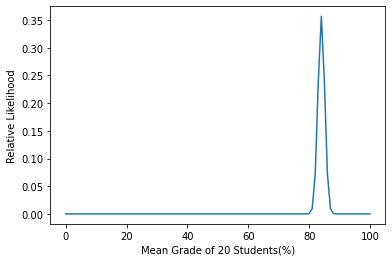

In [ ]:
# Plotting a normal curve using the mean and SEM
mean = population_mean
# The population standard deviation equals the square root of the population variance
population_std = population_variance ** .5
# The SEM equals population_std divided by the square root of the sample size
sem = population_std / (20 ** 0.5)
grade_range = range(101)
normal_likelihoods = stats.norm.pdf(grade_range, mean , sem)

plt.plot(grade_range, normal_likelihoods)
plt.xlabel("Mean Grade of 20 Students(%)")
plt.ylabel("Relative Likelihood")
plt.show()

The area beneath the plotted curve approaches zero at values higher than 89%. That
area is also equal to the probability of a given observation.

Therefore, the probability
of observing a mean grade that’s at or above 90% is incredibly low. Still, to be sure, we
need to compute the actual probability. 

Thus, we need to somehow accurately measure
the area under the normal distribution.

###Computing the area beneath a normal curve

One simple solution is to subdivide the normal
curve into small, trapezoidal units. This ancient technique is referred to as the trapezoidal rule.

A trapezoid is a four-sided polygon with two parallel sides; the trapezoid’s
area is equal to the sum of these parallel sides multiplied by half the distance between
them. 

Summing over multiple consecutive trapezoid areas approximates the area over
an interval.

Let’s apply the trapezoidal rule to our normal distribution.

In [ ]:
# Approximating the area using the trapezoidal rule

# The area of each trapezoid equals the sum of two consecutive likelihoods divided by 2.
total_area = np.sum([normal_likelihoods[i: i + 2].sum() / 2 for i in range(normal_likelihoods.size - 1)])

assert total_area == np.trapz(normal_likelihoods)
print(f"Estimated area under the curve is {total_area}")

Estimated area under the curve is 1.0000000000384808


The estimated area is very close to 1.0, but its not exactly equal to 1.0. We can access a mathematically exact solution in SciPy, using the `stats.norm.sf` method.

The survival function
equals the distribution’s area over an interval that’s greater than some x.

In [ ]:
# Computing the total area using SciPy
assert stats.norm.sf(0, mean, sem) == 1.0

We expect `stats.norm.sf(mean, mean, sem)` to equal 0.5. This is because the mean perfectly splits the Normal curve into 2 equal halves. Meanwhile, we expect `np.trapz(normal_likelihoods[mean:])` to approximate but not fully equal 0.5. 

Lets confirm below.

In [ ]:
# Inputting the mean into the survival function
assert stats.norm.sf(mean, mean, sem) == 0.5

In [ ]:
estimated_area = np.trapz(normal_likelihoods[mean:])
print(f"Estimated area beyond the mean is {estimated_area}")

Estimated area beyond the mean is 0.5000000000192404


Now, lets execute stats.norm.sf(90, mean, sem). This will return the area over an interval of values lying beyond 90%. 

The area represents the likelihood of 20 students jointly acing an exam.

In [ ]:
# Computing the probability of a good collective grade
area = stats.norm.sf(90, mean, sem)
print(f"Probability of 20 students acing the exam is {area}")

Probability of 20 students acing the exam is 4.012555633463782e-08


It seems our final conclusion is imperfect. We did the best we could, given what we
knew, but some uncertainty remains. 

To eliminate that uncertainty, we’d need the
missing dates for the graded exams. 

Unfortunately, that data was not provided. Quite
commonly, statisticians are forced to make consequential decisions from limited records.

Consequently,
we must exercise great caution when we draw conclusions from incomplete
information.